In [19]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)

import pickle
import warnings
warnings.simplefilter(action='ignore')

import eli5

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectPercentile, SelectFromModel
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import ElasticNet
from xgboost.sklearn import XGBRegressor

In [20]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\House_Prices'
X_train = pd.read_csv(os.path.join(project_path, r'data\X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(project_path, r'data\y_train.csv'), index_col=0, names=['SalePrice'])

In [21]:
X_train.shape
X_train.head()

(1156, 78)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GrLivAndBsmtArea,GardenArea,BathsAboveGrd
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
922,-0.882943,0.361626,-0.046853,-0.076360,0.050746,-0.722945,-0.090707,0.029273,0.004747,-0.218285,-1.041421,-2.333072,0.106092,-2.882178,-1.802319,-0.828481,0.22196,2.372968,-0.848541,-0.506716,-0.135309,-1.381651,-1.495637,-0.770043,-0.835334,-0.724563,0.325226,-0.655392,-0.672194,0.087531,-0.609160,-0.226722,1.070444,0.32761,-0.344636,-0.738332,0.495982,0.14264,-0.165354,0.26008,0.26013,0.410889,1.206368,-0.112458,1.279270,2.997177,-0.246796,0.784304,3.211155,1.378044,4.335645,-0.807123,1.507705,0.243828,-0.955827,-0.953355,-2.678136,2.470810,-1.962758,-2.439277,-2.565187,-3.669112,-3.813887,-3.758568,-0.962505,0.895953,-0.411301,-0.117533,-0.304319,-0.064715,-0.090533,1.007787,0.133139,-0.007204,0.188693,1.101861,-0.243582,2.591685
402,0.152736,0.361626,-0.143340,-0.078574,0.050746,1.007382,-0.090707,0.029273,0.004747,-0.218285,0.663625,0.249893,0.106092,0.132944,-0.280737,0.632147,0.22196,-1.156800,-1.043169,-0.506716,-0.135309,0.919350,0.961825,-0.770043,-0.835334,1.020364,0.325226,1.045714,0.612786,0.087531,1.246118,1.004957,-0.701864,0.32761,-0.344636,1.354299,0.575473,0.14264,0.878610,0.26008,0.26013,0.501841,-0.853809,-0.112458,-0.291357,-0.839209,-0.246796,0.784304,-0.753569,0.155906,-0.222441,0.710944,-0.337562,0.243828,0.586170,1.245826,0.565060,-1.076914,1.425175,0.314783,-0.292312,0.287973,0.299336,0.289387,-0.962505,-1.078858,-0.411301,-0.117533,-0.304319,-0.064715,-0.090533,0.263732,-1.376628,2.096239,1.336575,0.152355,-0.046861,0.060675
281,1.188416,0.361626,0.626159,0.414103,0.050746,-0.722945,-0.090707,0.029273,0.004747,-0.218285,0.322616,0.249893,0.106092,0.132944,1.240845,0.632147,0.22196,-0.595996,-0.215999,-0.506716,-0.135309,0.152349,0.259693,0.733988,1.309082,1.020364,0.325226,-0.655392,0.612786,0.087531,1.246118,1.004957,0.470521,0.32761,-0.344636,-0.164851,-0.537816,0.14264,-0.165354,0.26008,0.26013,0.165245,1.181578,-0.112458,0.960071,-0.839209,-0.246796,0.784304,1.228793,0.155906,-0.222441,0.710944,0.277527,0.243828,0.586170,0.512766,0.565060,-0.507939,1.425175,0.314783,0.500314,0.287973,0.299336,0.289387,-0.962505,0.982818,-0.411301,6.186724,-0.304319,-0.064715,-0.090533,-1.968434,-0.621744,-0.007204,0.188693,0.357599,0.312716,1.326180
1402,1.188416,0.361626,-0.291537,-0.403086,0.050746,1.007382,-0.090707,0.029273,0.004747,-0.218285,-0.018393,0.249893,0.106092,0.132944,1.240845,-0.098167,0.22196,-1.057834,-0.897198,-0.506716,-0.135309,0.919350,0.961825,-0.770043,-0.835334,-0.724563,0.325226,1.045714,-0.672194,0.087531,-0.609160,1.004957,0.828531,0.32761,-0.344636,-1.209415,-0.462299,0.14264,0.878610,0.26008,0.26013,-0.794601,1.163225,-0.112458,0.296746,1.078984,-0.246796,0.784304,1.228793,0.155906,-0.222441,-0.807123,0.892616,0.243828,0.586170,0.512766,0.565060,-0.976507,1.425175,0.314783,-0.301690,0.287973,0.299336,0.289387,0.853227,0.928766,-0.411301,-0.117533,-0.304319,-0.064715,-0.090533,-0.852351,0.133139,-0.007204,0.188693,-0.088108,-0.429756,1.326180
132,1.188416,0.361626,0.047887,0.570405,0.050746,1.007382,-0.090707,0.029273,-1.381289,-0.218285,-0.018393,0.249893,0.10609

In [22]:
y_train = np.log(y_train)
y_train.head()

,SalePrice
922,11.890677
402,12.013640
281,12.339291
1402,12.170445
132,12.404924


In the next lines of code I will try out different methods of feature importance assesment and rank variables using each of these methods. The final subset of features will be selected basing on the sum of rankings coming from these methods.

## Feature importance based on correlation with SalePrice

In [23]:
corr = pd.concat([X_train, y_train], axis=1).corr()
corr = np.abs(corr)
imp_corr = corr['SalePrice'].sort_values(ascending=False).reset_index().rename(columns = 
                                                                               {'index': 'Feature', 'SalePrice': 'Correlation'})
imp_corr['Corr_Rank'] = imp_corr['Correlation'].rank(ascending=False) - 1
# delete SalePrice from ranking
imp_corr = imp_corr[imp_corr['Corr_Rank']>0].set_index('Feature')
imp_corr.head(10)

,Correlation,Corr_Rank
Feature,,
GrLivAndBsmtArea,0.813707,1.0
OverallQual,0.809557,2.0
Neighborhood,0.732880,3.0
GrLivArea,0.730271,4.0
GarageCars,0.681717,5.0
ExterQual,0.666859,6.0
GarageArea,0.647292,7.0
KitchenQual,0.644924,8.0
BsmtQual,0.636214,9.0


## Feature importance from models

In [24]:
en = ElasticNet(alpha=0.01, random_state=1)
en.fit(X_train, y_train)
imp_en = pd.DataFrame(np.abs(en.coef_), index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
imp_en['En_Rank'] = imp_en['Importance'].rank(ascending=False)
imp_en.head(10)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

,Importance,En_Rank
GrLivAndBsmtArea,0.079000,1.0
OverallQual,0.072297,2.0
GrLivArea,0.066554,3.0
Neighborhood,0.042039,4.0
LotArea,0.031532,5.0
YearRemodAdd,0.024841,6.0
SaleCondition,0.022762,7.0
OverallCond,0.022337,8.0
GarageCars,0.019880,9.0
KitchenQual,0.019169,10.0


In [25]:
rf = RandomForestRegressor(n_estimators=200, random_state=1)
rf.fit(X_train, y_train)
imp_rf = pd.DataFrame(rf.feature_importances_, 
                      index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
imp_rf['Rf_Rank'] = imp_rf['Importance'].rank(ascending=False)
imp_rf.head(10)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

,Importance,Rf_Rank
OverallQual,0.423044,1.0
GrLivAndBsmtArea,0.316779,2.0
Neighborhood,0.051708,3.0
GrLivArea,0.017588,4.0
YearRemodAdd,0.014161,5.0
GarageArea,0.010702,6.0
BsmtFinSF1,0.010501,7.0
YearBuilt,0.010365,8.0
BsmtUnfSF,0.008317,9.0
LotArea,0.007574,10.0


In [26]:
xgb = XGBRegressor(n_estimators=200, random_state=1)
xgb.fit(X_train, y_train)
imp_xgb = pd.DataFrame(xgb.feature_importances_, 
                      index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
imp_xgb['Xgb_Rank'] = imp_rf['Importance'].rank(ascending=False)
imp_xgb.head(10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

,Importance,Xgb_Rank
GarageFinish,0.221374,27.0
GarageCars,0.184509,20.0
FireplaceQu,0.064999,31.0
OverallQual,0.063190,1.0
GrLivAndBsmtArea,0.059408,2.0
KitchenQual,0.056205,19.0
GarageType,0.052048,15.0
BsmtQual,0.042206,26.0
Neighborhood,0.032727,3.0
CentralAir,0.018927,14.0


## Permutation Importance

In [27]:
en = ElasticNet(alpha=0.01, random_state=1)
en.fit(X_train, y_train)
perm = PermutationImportance(en, random_state=1).fit(X_train, y_train)
perm_imp_en = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_en = perm_imp_en.set_index('feature')
perm_imp_en['Perm_En_Rank'] = perm_imp_en['weight'].rank(ascending=False)
perm_imp_en.head(10)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

,weight,std,Perm_En_Rank
feature,,,
GrLivAndBsmtArea,0.079599,0.002361,1.0
OverallQual,0.072209,0.004216,2.0
GrLivArea,0.058888,0.001835,3.0
Neighborhood,0.027027,0.001483,4.0
LotArea,0.015064,0.001037,5.0
YearRemodAdd,0.009563,0.000875,6.0
SaleCondition,0.008659,0.000873,7.0
OverallCond,0.007781,0.000957,8.0
GarageCars,0.006934,0.000797,9.0


In [28]:
rf = RandomForestRegressor(n_estimators=200, oob_score=True, random_state=1)
rf.fit(X_train, y_train)
perm = PermutationImportance(rf, random_state=1).fit(X_train, y_train)
perm_imp_rf = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_rf = perm_imp_rf.set_index('feature')
perm_imp_rf['Perm_Rf_Rank'] = perm_imp_rf['weight'].rank(ascending=False)
perm_imp_rf.head(10)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

,weight,std,Perm_Rf_Rank
feature,,,
GrLivAndBsmtArea,0.400091,0.016465,1.0
OverallQual,0.242952,0.022660,2.0
Neighborhood,0.060692,0.002463,3.0
YearRemodAdd,0.020868,0.001722,4.0
GrLivArea,0.014548,0.000462,5.0
GarageArea,0.009041,0.000401,6.0
BsmtFinSF1,0.008827,0.000239,7.0
BsmtUnfSF,0.008276,0.000844,8.0
YearBuilt,0.007228,0.000495,9.0


In [29]:
xgb = XGBRegressor(n_estimators=200, random_state=1)
xgb.fit(X_train, y_train)
perm = PermutationImportance(xgb, random_state=1).fit(X_train, y_train)
perm_imp_xgb = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_xgb = perm_imp_xgb.set_index('feature')
perm_imp_xgb['Perm_Xgb_Rank'] = perm_imp_xgb['weight'].rank(ascending=False)
perm_imp_xgb.head(10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

,weight,std,Perm_Xgb_Rank
feature,,,
GrLivAndBsmtArea,0.235625,0.009566,1.0
OverallQual,0.057692,0.003160,2.0
Neighborhood,0.038731,0.002435,3.0
YearRemodAdd,0.017117,0.001066,4.0
LotArea,0.011211,0.000545,5.0
GrLivArea,0.009624,0.000239,6.0
GarageCars,0.008569,0.000656,7.0
KitchenQual,0.007926,0.000800,8.0
BsmtUnfSF,0.007728,0.000605,9.0


## Feature importances ranking

In [30]:
feat_imp_ranking = pd.concat([imp_corr, imp_en, imp_rf, imp_xgb, perm_imp_en, perm_imp_rf, perm_imp_xgb], axis=1)
rank_columns = [col for col in feat_imp_ranking if 'Rank' in col]
feat_imp_ranking = feat_imp_ranking[rank_columns]
feat_imp_ranking['Overall_Rank'] = feat_imp_ranking.sum(axis=1)
feat_imp_ranking = feat_imp_ranking.sort_values('Overall_Rank', ascending=True)
feat_imp_ranking.head(30)

,Corr_Rank,En_Rank,Rf_Rank,Xgb_Rank,Perm_En_Rank,Perm_Rf_Rank,Perm_Xgb_Rank,Overall_Rank
GrLivAndBsmtArea,1.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0
OverallQual,2.0,2.0,1.0,1.0,2.0,2.0,2.0,12.0
Neighborhood,3.0,4.0,3.0,3.0,4.0,3.0,3.0,23.0
GrLivArea,4.0,3.0,4.0,4.0,3.0,5.0,6.0,29.0
YearRemodAdd,17.0,6.0,5.0,5.0,6.0,4.0,4.0,47.0
GarageArea,7.0,13.0,6.0,6.0,15.0,6.0,13.0,66.0
LotArea,29.0,5.0,10.0,10.0,5.0,10.0,5.0,74.0
KitchenQual,8.0,10.0,19.0,19.0,12.0,20.0,8.0,96.0
GarageCars,5.0,9.0,20.0,20.0,9.0,28.0,7.0,98.0
1stFlrSF,12.0,14.0,11.0,11.0,13.0,12.0,25.0,98.0


<Figure size 1080x1080 with 0 Axes>

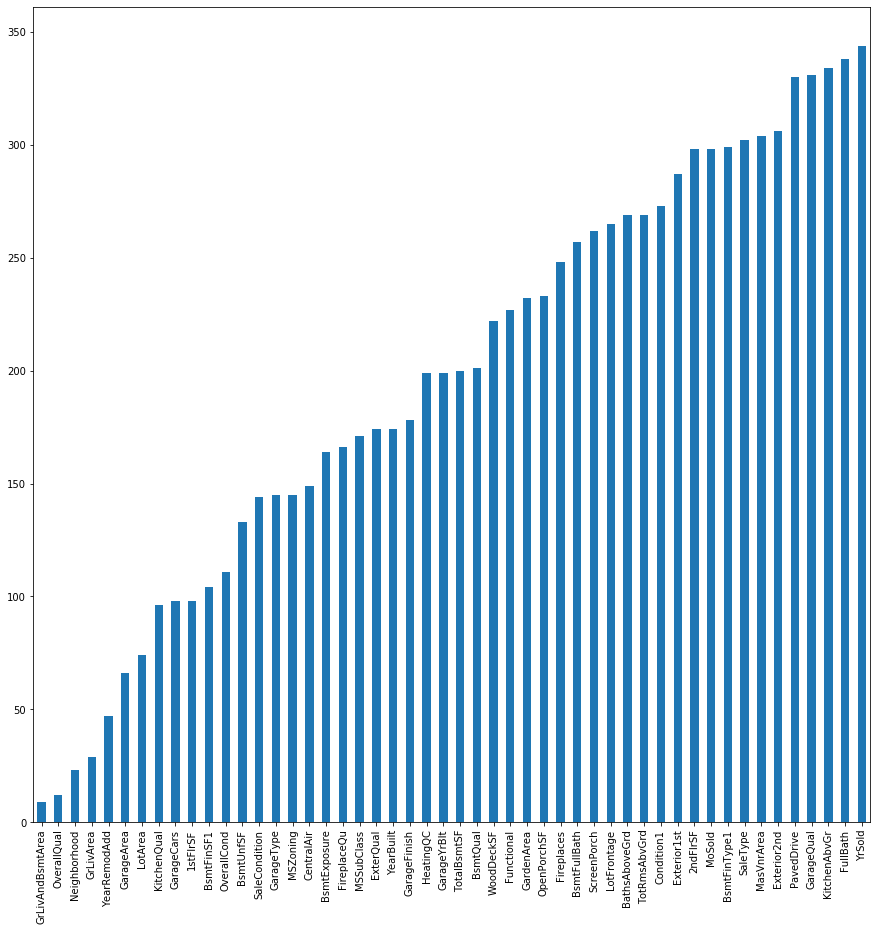

In [31]:
plt.figure(figsize=(15,15))
feat_imp_ranking['Overall_Rank'].head(50).plot.bar()

In [32]:
selected_features = feat_imp_ranking[feat_imp_ranking['Overall_Rank']<=149].index.tolist()
print(selected_features)

['GrLivAndBsmtArea', 'OverallQual', 'Neighborhood', 'GrLivArea', 'YearRemodAdd', 'GarageArea', 'LotArea', 'KitchenQual', 'GarageCars', '1stFlrSF', 'BsmtFinSF1', 'OverallCond', 'BsmtUnfSF', 'SaleCondition', 'GarageType', 'MSZoning', 'CentralAir']


In [33]:
with open(os.path.join(project_path, r'data\selected_features.txt'), "wb") as f:
      pickle.dump(selected_features, f)